In [21]:
import numpy as np
import matplotlib.pyplot as plt
from model import calculate_fitness, r0, nyear, cg, phi, epsilon, gamma, lam, n_char, deg_to_km

In [22]:
def standard_woa_solve(demand_points, max_iter=500, pop_size=30, dim=28):
    print(f"Starting Standard WOA Optimization for {max_iter} iterations")

    # Define Bounds
    LOWER_BOUND = np.array([113.8, 22.45])
    UPPER_BOUND = np.array([114.4, 22.85])
    
    # Tile bounds to match dimension (14 stations * 2 coords = 28 dim)
    lb_tiled = np.tile(LOWER_BOUND, int(dim/2))
    ub_tiled = np.tile(UPPER_BOUND, int(dim/2))

    # 2. Initialize Population (Standard Random Uniform)
    # WOA uses simple random initialization, unlike IWOA's Chaos Map
    population = np.random.uniform(lb_tiled, ub_tiled, (pop_size, dim))

    # 3. Calculate Initial Fitness
    fitness = np.array([calculate_fitness(ind.reshape(14,2), demand_points) for ind in population])

    # Find Initial Leader
    best_idx = np.argmin(fitness)
    best_whale = population[best_idx].copy()
    best_score = fitness[best_idx]

    convergence_curve = []

    # 4. Main Optimization Loop
    for t in range(max_iter):
        
        a = 2 - 2 * t / max_iter # Linearly drops from 2 to 0
        
        for i in range(pop_size):
            r1 = np.random.rand()
            r2 = np.random.rand()
            
            A = 2 * a * r1 - a  # eq3
            C = 2 * r2          # eq4
            
            p = np.random.rand() # Strategy chooser
            
            if p < 0.5:
                if np.abs(A) < 1: 
                    # Encircling Prey (Bubble Net)  Move towards leader
                    D = np.abs(C * best_whale - population[i])
                    population[i] = best_whale - A * D
                else: 
                    # Global Search (Exploration) - Move towards random whale
                    rand_idx = np.random.randint(0, pop_size)
                    rand_whale = population[rand_idx]
                    D = np.abs(C * rand_whale - population[i])
                    population[i] = rand_whale - A * D
            else: 
                # Spiral attack Updating Position
                distance_to_best = np.abs(best_whale - population[i])
                l = np.random.uniform(-1, 1)
                population[i] = distance_to_best * np.exp(l) * np.cos(2 * np.pi * l) + best_whale
        
        # 5. Check Bounds
        population = np.clip(population, lb_tiled, ub_tiled)
        
        # 6. Update Fitness & Leader
        fitness = np.array([calculate_fitness(ind.reshape(14,2), demand_points) for ind in population])
        
        current_best_idx = np.argmin(fitness)
        if fitness[current_best_idx] < best_score:
            best_score = fitness[current_best_idx]
            best_whale = population[current_best_idx].copy()
            
        convergence_curve.append(best_score)
        
    return best_whale, best_score, convergence_curve

In [23]:
import benchmark as bench

def standard_woa_benchmark_solve(func_name, max_iter=100, pop_size=30):
    # Get the specific math function details (Bounds, Dimension, Equation)
    fitness_func, lb, ub, dim = bench.get_function_details(func_name)
    
    if fitness_func is None:
        print(f"Error: {func_name} not found.")
        return 0

    # Initialize Population (STANDARD: Random Uniform, No Chaos)
    population = np.random.uniform(lb, ub, (pop_size, dim))
    
    # Calculate initial fitness
    fitness = np.array([fitness_func(ind) for ind in population])
    
    best_idx = np.argmin(fitness)
    best_whale = population[best_idx].copy()
    best_score = fitness[best_idx]
    
    # Optimization Loop
    for t in range(max_iter):
        
        # Standard Linear Decay
        a = 2 - 2 * t / max_iter 
        
        for i in range(pop_size):
            r1 = np.random.rand()
            r2 = np.random.rand()
            A = 2 * a * r1 - a
            C = 2 * r2
            p = np.random.rand()
            
            if p < 0.5:
                if np.abs(A) < 1: # Encircling
                    D = np.abs(C * best_whale - population[i])
                    population[i] = best_whale - A * D
                else: # Global Search
                    rand_idx = np.random.randint(0, pop_size)
                    rand_whale = population[rand_idx]
                    D = np.abs(C * rand_whale - population[i])
                    population[i] = rand_whale - A * D
            else: # Spiral
                dist = np.abs(best_whale - population[i])
                l = np.random.uniform(-1, 1)
                population[i] = dist * np.exp(l) * np.cos(2 * np.pi * l) + best_whale
        
        # Check Bounds & Update Fitness
        population = np.clip(population, lb, ub)
        fitness = np.array([fitness_func(ind) for ind in population])
        
        # Update Leader
        current_best_idx = np.argmin(fitness)
        if fitness[current_best_idx] < best_score:
            best_score = fitness[current_best_idx]
            best_whale = population[current_best_idx].copy()

    return best_score

In [24]:
if __name__ == "__main__":
    func_list = [f"F{i}" for i in range(1, 19)] # F1 to F18

    print(f"{'Function':<10} | {'Best Score (Standard WOA)':<25}")
    print("-" * 45)

    for func_name in func_list:
        # Run Solver
        best_score = standard_woa_benchmark_solve(func_name, max_iter=100, pop_size=30)
        
        # Print Result
        print(f"{func_name:<10} | {best_score:.5e}")

Function   | Best Score (Standard WOA)
---------------------------------------------
F1         | 2.33897e-14
F2         | 2.55677e-09
F3         | 6.04138e+04
F4         | 2.52546e-02
F5         | 2.87410e+01
F6         | 3.29888e-01
F7         | 4.04836e-04
F8         | -1.25590e+04
F9         | 2.30926e-14
F10        | 1.53254e-08
F11        | 5.80647e-14
F12        | 1.25735e-14
F13        | 8.71289e-17
F14        | 1.55038e+01
F15        | 3.95379e-04
F16        | 3.97887e-01
F17        | 3.03090e+01
F18        | 7.78270e+00


In [25]:
def print_financial_report(stations_flat, demand_points):
    stations = stations_flat.reshape(14, 2)
    num_stations = len(stations)

    # Re-calculate costs for display
    capital_recovery = (r0 * (1 + r0)**nyear) / ((1 + r0)**nyear - 1)
    variable_cost = (phi * n_char) + (epsilon * n_char)
    total_invest = cg + (num_stations * variable_cost)
    AC = total_invest * capital_recovery
    AO = total_invest * gamma
    F_CO = AC + AO 

    diff = demand_points[:, np.newaxis, :] - stations[np.newaxis, :, :]
    min_dists = np.min(np.sqrt(np.sum(diff**2, axis=2)) * deg_to_km, axis=1)
    F_Time = np.sum(min_dists) * lam
    
    violation = 0
    for i in range(num_stations):
        for j in range(i + 1, num_stations):
            if (np.sqrt(np.sum((stations[i] - stations[j])**2)) * deg_to_km) < 6.0: violation += 1
    F_Limit = (violation / 2) * 15000

    total = F_CO + F_Time + F_Limit
    
    print(f"--- FINAL COST BREAKDOWN (Standard WOA) ---")
    print(f"Construction Cost: {F_CO:,.2f} CNY")
    print(f"Travel Cost:       {F_Time:,.2f} CNY")
    print(f"Penalty Cost:      {F_Limit:,.2f} CNY")
    print(f"-------------------------------------------")
    print(f"TOTAL OBJECTIVE:   {total:,.2f} CNY")

--- FINAL COST BREAKDOWN (Standard WOA) ---
Construction Cost: 823,557.01 CNY
Travel Cost:       1,285.77 CNY
Penalty Cost:      7,500.00 CNY
-------------------------------------------
TOTAL OBJECTIVE:   832,342.78 CNY


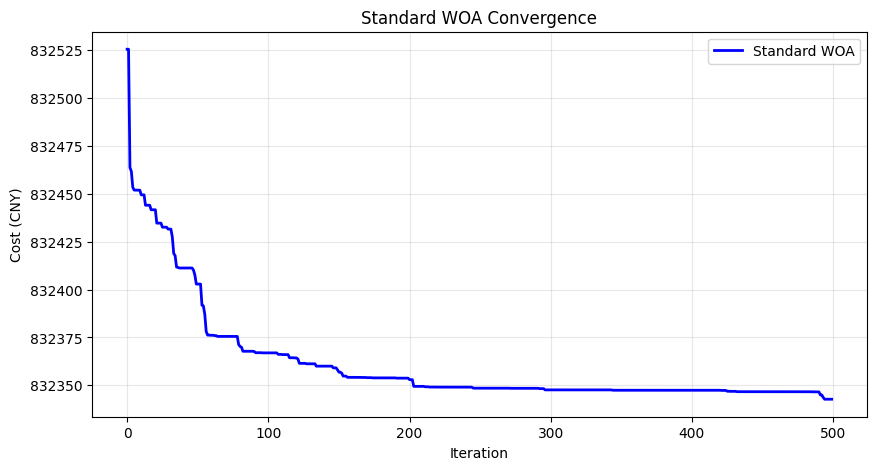

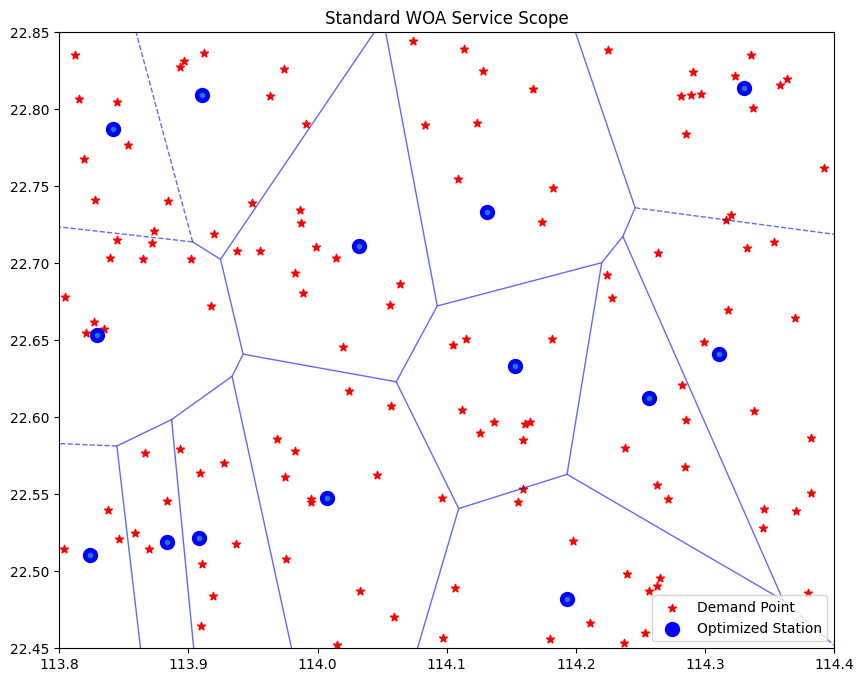

In [26]:
from IPython.display import clear_output
from scipy.spatial import Voronoi, voronoi_plot_2d

if __name__ == "__main__":
    np.random.seed(42)
    dx = np.random.uniform(113.8, 114.4, 130)
    dy = np.random.uniform(22.45, 22.85, 130)
    mock_demand = np.column_stack((dx, dy))

    print(f"Data Loaded: {len(mock_demand)} points ready for optimization.")
    print("Running Standard WOA (Please wait)...")
    
    woa_pos, woa_cost, woa_curve = standard_woa_solve(mock_demand, max_iter=500)

    # --- NEW PARTS START HERE ---
    clear_output(wait=True)

    # 1. Financial Table
    print_financial_report(woa_pos, mock_demand)

    # 2. Convergence Graph
    plt.figure(figsize=(10, 5))
    plt.plot(woa_curve, label='Standard WOA', color='blue', linewidth=2)
    plt.xlabel('Iteration')
    plt.ylabel('Cost (CNY)')
    plt.title('Standard WOA Convergence')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # 3. Voronoi Map
    best_stations = woa_pos.reshape(14, 2)
    vor = Voronoi(best_stations)

    fig, ax = plt.subplots(figsize=(10, 8))
    voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='blue', line_alpha=0.6)
    ax.scatter(mock_demand[:, 0], mock_demand[:, 1], c='red', marker='*', label='Demand Point')
    ax.scatter(best_stations[:, 0], best_stations[:, 1], c='blue', marker='o', s = 100, label='Optimized Station')

    ax.set_xlim(113.8, 114.4)
    ax.set_ylim(22.45, 22.85)
    ax.set_title("Standard WOA Service Scope")
    ax.legend()
    plt.show()